# Pandas create pivot

In [23]:
import glob
from chess import SQUARE_NAMES, square_name
import os
import sys
from multiprocessing import Process

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [24]:
paths = glob.glob('*PARSED*')
pgns = [file for file in os.listdir() if "PARSED" in file]
parsedpath = paths[0]
# paths

IndexError: list index out of range

In [196]:
#create a DataFrame with the index set to chess square names, and an empty count column
check_df = pd.DataFrame(SQUARE_NAMES,columns=['king_square_name'])
check_df.index = check_df['king_square_name']
check_df['frequency'] = 0

stale_df = pd.DataFrame(SQUARE_NAMES,columns=['king_square_name'])
stale_df.index = stale_df['king_square_name']
stale_df['frequency'] = 0

check_df.head()

,king_square_name,frequency
king_square_name,,
a1,a1,0
b1,b1,0
c1,c1,0
d1,d1,0
e1,e1,0


In [ ]:
%%time
pgns = 0
games = 0
cm = 0

for path in paths:
    pgns += 1    
    with open(path,'r') as file: 

        # Populate the dataframe
        for line in file:
            games += 1
            result,king,queen = line.split(',')

            if result == '1' or result == '0': # if checkmate
                cm += 1
                king_square = square_name(int(king))                
                check_df.at[king_square,'frequency'] += 1 

#             else: # if stalemate
# #                 pass # this takes 6-10x longer
#                 king_square_white,king_square_black = [square_name(int(king)) for king in king.split('-')]
#                 stale_df.at[king_square_white,'frequency'] += 1 
#                 stale_df.at[king_square_black,'frequency'] += 1 

print(f"{pgns} pgn files")
print(f"{round(games/1000000,2)} million games")
print(f"{round(cm/1000)} thousand checkmates\n")    

In [197]:
%%time
def main_parse(parsed_pgn):
    '''
    1) Converts the parsed_pgn files into a 64-len pandas data frame
    2) Writes this data frame to the disk as a .csv
    '''
    with open(parsed_pgn,'r') as file:
        for line in file:
            is_checkmate,queen_square = line.replace('\n','').split(',')
            if is_checkmate == '1':
                check_df.at[queen_square,'frequency'] += 1
            else: # if stalemate
                queen_square_white,queen_square_black = queen_square.split('-')
                stale_df.at[queen_square_white,'frequency'] += 1 
                stale_df.at[queen_square_black,'frequency'] += 1 
                
    check_df.to_csv(f"CHECK_{parsed_pgn}.csv")
    stale_df.to_csv(f"STALE_{parsed_pgn}.csv")
    
def main_parse2(parsed_pgn):
    '''
    THIS HANDLES MULTIPLE PIECES
    1) Converts the parsed_pgn files into a 64-len pandas data frame
    2) Writes this data frame to the disk as a .csv
    '''
    count = 0
    with open(parsed_pgn,'r') as file:
        for line in file:
            try:
                is_checkmate,rook,bishop,knight,pawn = line.replace('\n','').split(',')

                if (is_checkmate == '1') and (len(bishop) == 2):
                    check_df.at[bishop,'frequency'] += 1

                if (is_checkmate == '0') and (bishop != 'None'):
                    count += 1
                    white,black = bishop.split('-')
                    stale_df.at[white,'frequency'] += 1
                    stale_df.at[black,'frequency'] += 1
            except:
                pass
                    
    check_df.to_csv(f"CHECK_pawn_{parsed_pgn}.csv")
    stale_df.to_csv(f"STALE_pawn_{parsed_pgn}.csv")
    print(f'found {count} stalemate games')
    
def multiparser(parsed_pgn_list):
    process_list = []
    for parsed_pgn in parsed_pgn_list:
        process = Process(target=main_parse, args=(parsed_pgn,))
        process_list.append(process)
    for process in process_list:
        process.start()
    for p in process_list:
        process.join()
            
main_parse2('results-all-pieces.txt')

found 104448 stalemate games
CPU times: user 2.53 s, sys: 25.5 ms, total: 2.56 s
Wall time: 2.59 s


In [74]:
%%time
xpaths = np.array(paths)
xpaths = xpaths.reshape(9,8)

def multiparser2(list_of_lists):
    '''
    This multiparser takes in a list of lists (created via np.reshape())
    and passes them into the parser in chunks == to the number of available cores
    '''
    count = 0
    for lst in list_of_lists:
        count += 1
        print(f"Found {count} list_of_lists")
        process_list = []
        for parsed_pgn in lst:
            process = Process(target=main_parse, args=(parsed_pgn,))
            process_list.append(process)
        for process in process_list:
            process.start()
        for p in process_list:
            process.join()

multiparser2(xpaths)

ValueError: cannot reshape array of size 0 into shape (9,8)

In [192]:
%%time
# Merge the dataframes
checkmates = glob.glob("CHECK_pawn*")
stalesmates = glob.glob("STALE_pawn*")

def reshape_dataframes(dataframes):
    '''
    1) Takes a list of CHECK_PARSED pgns files
    2) Merges and sums the chess square 'frequency' column
    3) Reshapes this column into an 8x8 chess board
    '''
    freqs = []
    for df in dataframes:
        df = open(df)
        df = pd.read_csv(df)
        df = df['frequency']
        freqs.append(df)

    freqs = sum(freqs)
    freqs = np.array(freqs)
    freqs = freqs.reshape(8,8)
    
    return freqs

reshaped_checkmates = reshape_dataframes(checkmates)
reshaped_stalemates = reshape_dataframes(stalesmates)

CPU times: user 5.5 ms, sys: 1.56 ms, total: 7.06 ms
Wall time: 9.56 ms


In [193]:
print(checkmates)
# reshaped_checkmates[0] = [0] * 8
# reshaped_checkmates[7] = [0] * 8
# reshaped_checkmates[0][3] = reshaped_checkmates[0][3]/2
reshaped_stalemates

['CHECK_pawn_results-all-pieces.txt.csv']


array([[  258,   580, 17564,   604,   436, 26808,   130,   174],
       [ 1448,  7062,  2762,  6422,  9642,  1160,  9522,   738],
       [ 1928,  5532,  2676, 11892, 11784,  3618,  3384,  1624],
       [ 1154,  1350, 14184,  2392,  2238,  8342,  1466,  1680],
       [  814,  4798,  1610,  2878,  2194,  1404,  7828,  1380],
       [ 1096,   836,  1804,  1622,  1782,  2112,  1316,  3304],
       [  550,   756,  1060,   600,   866,  1534,   970,   796],
       [  884,   336,   202,   998,   272,   408,   414,   918]])

# Create Heatmaps

The most common square for a king to be checkmated on, from 5.9 thousand games
CPU times: user 92.2 ms, sys: 7.44 ms, total: 99.6 ms
Wall time: 102 ms


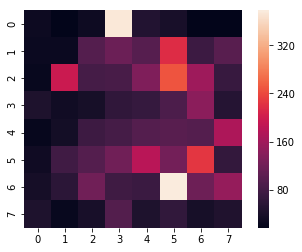

In [194]:
%%time
num_cm = round(sum(sum(reshaped_checkmates))/1000,1)
print( f"The most common square for a king to be checkmated on, from {num_cm} thousand games" )
heatmap = sns.heatmap(reshaped_checkmates, square=True)
heatmap = heatmap.get_figure()
heatmap.savefig("heatmap-check-pawn")

The most common square for a king to end up on in a draw, from 104.45 thousand games
CPU times: user 93.4 ms, sys: 8.33 ms, total: 102 ms
Wall time: 102 ms


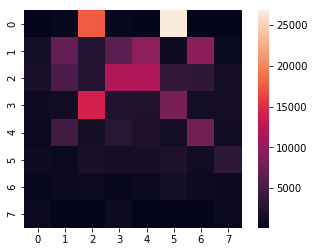

In [195]:
%%time
num_sm = round(sum(sum(reshaped_stalemates))/1000,1)
print( f"The most common square for a king to end up on in a draw, from {num_sm/2} thousand games" )
heatmap = sns.heatmap(reshaped_stalemates, square=True)
heatmap = heatmap.get_figure()
heatmap.savefig("heatmap-stale")

In [34]:
#Started out with 10 billion lines in text files, representing 450 million games of chess (400 GB)
#Trimmed this down one line per game, i.e., 450 million lines (1.5 GB)
#Pivoted these 400m lines to fewer than 1 MB (just 224 bytes).
#And that's how you go from 400GB down to 224 bytes, half a billion games down to 4 heatmaps.
sys.getsizeof(reshaped_checkmates) + sys.getsizeof(reshaped_stalemates)

224